In [1]:
import pandas as pd 
import numpy as np
import os
import cv2
from tqdm import tqdm

import matplotlib.pyplot as plt

PATH = '../input/landsat8/landsat8/'

In [2]:
def extract_images_random(bands, mask, number, size = (250, 250)):
    minibands = np.empty((number, size[0], size[1], bands.shape[2]))
    masks = np.empty((number,size[0], size[1], 1))
    for k in range(number):
        while True:
            # check for correctness
            i = np.random.randint(0, bands.shape[0] - size[0])
            j = np.random.randint(0,bands.shape[1] - size[1])
            minibands[k, :, :, :] = bands[i: i + size[0], j : j + size[1], :]/255
            masks[k] = mask[i: i + size[0], j : j + size[1], :]/255
            if len(np.unique(masks[k])) > 1:
                break
    return minibands, masks

In [3]:
import keras.backend as K
import tensorflow as tf
def castF(x):
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)



def iou_loss_core(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())


def IoU(true, pred): #any shape can go - can't be a loss function

    tresholds = [0.5 + (i*.05)  for i in range(10)]

    #flattened images (batch, pixels)
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = castF(K.greater(pred, 0.5))

    #total white pixels - (batch,)
    trueSum = K.sum(true, axis=-1)
    predSum = K.sum(pred, axis=-1)

    #has mask or not per image - (batch,)
    true1 = castF(K.greater(trueSum, 1))    
    pred1 = castF(K.greater(predSum, 1))

    #to get images that have mask in both true and pred
    truePositiveMask = castB(true1 * pred1)

    #separating only the possible true positives to check iou
    testTrue = tf.boolean_mask(true, truePositiveMask)
    testPred = tf.boolean_mask(pred, truePositiveMask)

    #getting iou and threshold comparisons
    iou = iou_loss_core(testTrue,testPred) 
    truePositives = [castF(K.greater(iou, tres)) for tres in tresholds]

    #mean of thressholds for true positives and total sum
    truePositives = K.mean(K.stack(truePositives, axis=-1), axis=-1)
    truePositives = K.sum(truePositives)

    #to get images that don't have mask in both true and pred
    trueNegatives = (1-true1) * (1 - pred1) # = 1 -true1 - pred1 + true1*pred1
    trueNegatives = K.sum(trueNegatives) 

    return (truePositives + trueNegatives) / castF(K.shape(true)[0])

Using TensorFlow backend.


In [4]:
nums = 300
size = (256,256)
band_n = 7 # change band numb
total_tr = nums * (len(os.listdir(PATH))- 1)
total_val = nums 
tr_bands = np.empty((total_tr, size[0], size[1], band_n))
tr_target = np.empty((total_tr, size[0], size[1], 1))

val_bands = np.empty((total_val, size[0], size[1], band_n))
val_target = np.empty((total_val, size[0], size[1], 1))

k = 0
index = 0
for value in tqdm(os.listdir(PATH)):
    if index != 5:
        path = PATH + value + '/'
        mask = cv2.imread(path + 'QB.tif')
        mask = mask[:, :, 1].reshape(mask.shape[0], mask.shape[1], 1)
        bnds = np.empty((mask.shape[0], mask.shape[1], band_n))
        for value in sorted(os.listdir(path)):
            if value.split('.')[0][0] == 'B':
                n = int(value.split('.')[0][1:])
                if n<8: 
                    bnd = cv2.imread(path + value)[:, :, 0]
                    bnds[:, :, n-1] = bnd
                    k+=1
        k = 0
        mnbands, msk = extract_images_random(bnds, mask, nums, size = size)
        tr_bands[index*nums : (index+1)*nums, :, :, :] = mnbands
        tr_target[index*nums : (index+1)*nums, :, :, :] = msk
        index += 1
    else:
        path = PATH + value + '/'
        mask = cv2.imread(path + 'QB.tif')
        mask = mask[:, :, 1].reshape(mask.shape[0], mask.shape[1], 1)
        bnds = np.empty((mask.shape[0], mask.shape[1], band_n))
        for value in sorted(os.listdir(path)):
            if value.split('.')[0][0] == 'B':
                n = int(value.split('.')[0][1:])
                if n<8: 
                    bnd = cv2.imread(path + value)[:, :, 0]
                    bnds[:, :, n-1] = bnd
                    k+=1
        k = 0
        mnbands, msk = extract_images_random(bnds, mask, nums, size = size)
        val_bands[0: nums, :, :, :] = mnbands
        val_target[0: nums, :, :, :] = msk
    %reset_selective -f mask
    %reset_selective -f bnd
    %reset_selective -f bnds
    %reset_selective -f mnbands
    %reset_selective -f msk

100%|██████████| 6/6 [01:18<00:00, 12.98s/it]


In [5]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate

from keras import losses, optimizers, metrics

In [6]:
# U-Net model
inputs = Input((256, 256, band_n))
s = Lambda(lambda x: x) (inputs)

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model_unet = Model(inputs=[inputs], outputs=[outputs])
model_unet.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 7)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 7)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 1024        lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)  

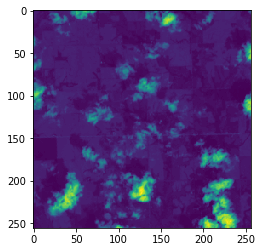

In [7]:
plt.imshow(val_bands[50, :, :, 0])

In [8]:
inputs = Input((256, 256, band_n))
s = Lambda(lambda x: x)(inputs)

c1 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(s)
c2 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(c1)
c3 = MaxPooling2D((2,2))(c2)
c4 = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(c3)
c5 = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(c4)
c6 = MaxPooling2D((2,2))(c5)
u1 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same') (c6)
u2 = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(u1)
u3 = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(u2)
u4 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same') (u3)
u5 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(u4)
u6 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(u5)

outputs = Conv2D(1, (3,3), activation = 'sigmoid', padding = 'same')(u6)
model_deconvnet = Model(inputs, outputs)
model_deconvnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 7)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 256, 256, 7)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 256, 256, 128)     8192      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 256, 256, 128)     147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128, 128, 64)      73792     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 128, 128, 64)      36928     
__________

In [9]:
model_unet.compile(optimizer= optimizers.RMSprop(lr = 0.0001),
             loss = losses.binary_crossentropy,
             metrics = [IoU, metrics.binary_accuracy])

model_deconvnet.compile(optimizer= optimizers.RMSprop(lr = 0.0001),
             loss = losses.binary_crossentropy,
             metrics = [IoU, metrics.binary_accuracy])

In [10]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_binary_accuracy',
                              patience = 30,
                              verbose = 1,
                              mode = 'max')

In [11]:
history_unet = model_unet.fit(tr_bands, tr_target, 
                    epochs=100,
                    verbose=1,
                    batch_size = 16,
                    validation_data=(val_bands, val_target),
                    callbacks = [early_stopping])

Instructions for updating:
Use tf.cast instead.
Train on 1500 samples, validate on 300 samples
Epoch 1/100
1500/1500 [==============================] - 26s 17ms/step - loss: 0.6304 - IoU: 0.2949 - binary_accuracy: 0.6074 - val_loss: 0.3646 - val_IoU: 0.2910 - val_binary_accuracy: 0.8705
Epoch 2/100
1500/1500 [==============================] - 20s 14ms/step - loss: 0.4983 - IoU: 0.3459 - binary_accuracy: 0.7324 - val_loss: 0.5266 - val_IoU: 0.1417 - val_binary_accuracy: 0.7284
Epoch 3/100
1500/1500 [==============================] - 20s 13ms/step - loss: 0.4092 - IoU: 0.3573 - binary_accuracy: 0.8175 - val_loss: 0.2610 - val_IoU: 0.3483 - val_binary_accuracy: 0.8946
Epoch 4/100
1500/1500 [==============================] - 21s 14ms/step - loss: 0.3627 - IoU: 0.3803 - binary_accuracy: 0.8424 - val_loss: 0.3295 - val_IoU: 0.2977 - val_binary_accuracy: 0.8672
Epoch 5/100
1500/1500 [==============================] - 20s 13ms/step - loss: 0.3297 - IoU: 0.3964 - binary_accuracy: 0.8597 - val_l

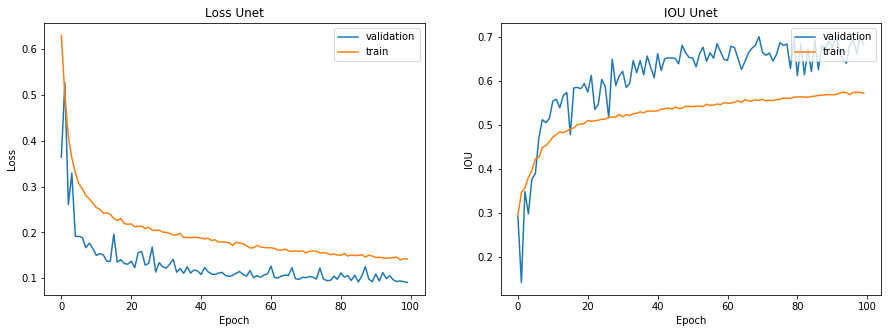

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
ax1.set_title('Loss ' + 'Unet')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(history_unet.history['val_loss'], label = 'validation')
ax1.plot(history_unet.history['loss'], label = 'train')
ax1.legend(loc="upper right")

ax2.set_title('IOU Unet')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('IOU')
ax2.plot(history_unet.history['val_IoU'], label = 'validation')
ax2.plot(history_unet.history['IoU'], label = 'train')
ax2.legend(loc="upper right")
plt.show()

In [13]:
history_deconvnet = model_deconvnet.fit(tr_bands, tr_target, 
                    epochs=100,
                    verbose=1,
                    batch_size = 16,
                    validation_data=(val_bands, val_target),
                    callbacks = [early_stopping])

Train on 1500 samples, validate on 300 samples
Epoch 1/100
1500/1500 [==============================] - 46s 31ms/step - loss: 0.4956 - IoU: 0.3467 - binary_accuracy: 0.7538 - val_loss: 0.4673 - val_IoU: 0.1727 - val_binary_accuracy: 0.8669
Epoch 2/100
1500/1500 [==============================] - 45s 30ms/step - loss: 0.3508 - IoU: 0.4014 - binary_accuracy: 0.8496 - val_loss: 0.1865 - val_IoU: 0.4780 - val_binary_accuracy: 0.9244
Epoch 3/100
1500/1500 [==============================] - 44s 30ms/step - loss: 0.3265 - IoU: 0.4237 - binary_accuracy: 0.8642 - val_loss: 0.1948 - val_IoU: 0.4850 - val_binary_accuracy: 0.9305
Epoch 4/100
1500/1500 [==============================] - 44s 30ms/step - loss: 0.3164 - IoU: 0.4293 - binary_accuracy: 0.8654 - val_loss: 0.3551 - val_IoU: 0.2837 - val_binary_accuracy: 0.8942
Epoch 5/100
1500/1500 [==============================] - 45s 30ms/step - loss: 0.2973 - IoU: 0.4439 - binary_accuracy: 0.8814 - val_loss: 0.2915 - val_IoU: 0.3407 - val_binary_accur

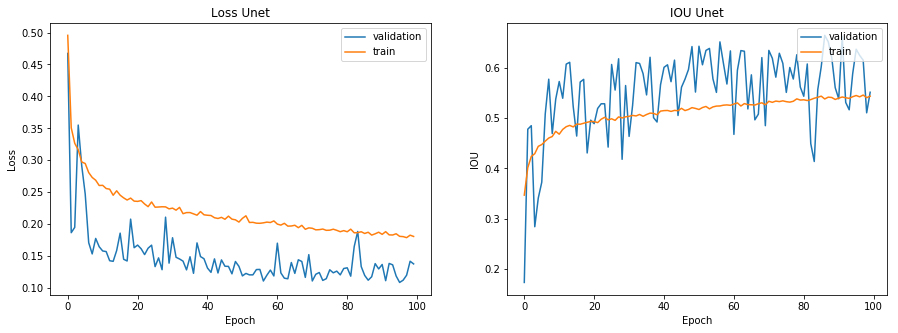

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
ax1.set_title('Loss ' + 'Unet')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(history_deconvnet.history['val_loss'], label = 'validation')
ax1.plot(history_deconvnet.history['loss'], label = 'train')
ax1.legend(loc="upper right")

ax2.set_title('IOU Unet')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('IOU')
ax2.plot(history_deconvnet.history['val_IoU'], label = 'validation')
ax2.plot(history_deconvnet.history['IoU'], label = 'train')
ax2.legend(loc="upper right")
plt.show()

In [15]:
from keras.layers import Average

inputs = Input((256, 256, band_n))
s = Lambda(lambda x: x) (inputs)

unet = model_unet(s)
unet.trainable = False
deconv_net = model_deconvnet(s)
deconv_net.trainable = False

outputs = Average()([unet, deconv_net])
final_model = Model(inputs=[inputs], outputs=[outputs])
final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 7)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 256, 256, 7)  0           input_3[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 256, 256, 1)  1941681     lambda_3[0][0]                   
__________________________________________________________________________________________________
model_2 (Model)                 (None, 256, 256, 1)  747457      lambda_3[0][0]                   
__________________________________________________________________________________________________
average_1 

In [16]:
final_model.compile(optimizer= optimizers.RMSprop(lr = 0.001),
             loss = losses.binary_crossentropy,
             metrics = [IoU, metrics.binary_accuracy])

In [17]:
model_unet.evaluate(val_bands, val_target, verbose = 1)

300/300 [==============================] - 3s 10ms/step


[0.09083156158526738, 0.6829999899864196, 0.9651171374320984]

In [18]:
model_deconvnet.evaluate(val_bands, val_target, verbose = 1)

300/300 [==============================] - 5s 16ms/step


[0.1376133801539739, 0.5516666626930237, 0.9485244750976562]

In [19]:
final_model.evaluate(val_bands, val_target, verbose = 1)

300/300 [==============================] - 5s 17ms/step


[0.09490905731916427, 0.6496666685740153, 0.9622383626302083]

In [20]:
model_json = final_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
final_model.save_weights("model.h5")

In [21]:
model_unet_json = model_unet.to_json()
with open("model_unet.json", "w") as json_file:
    json_file.write(model_unet_json)
model_unet.save_weights("model_unet.h5")

In [22]:
model_deconvnet_json = model_deconvnet.to_json()
with open("model_deconvnet.json", "w") as json_file:
    json_file.write(model_deconvnet_json)
model_deconvnet.save_weights("model_deconvnet.h5")

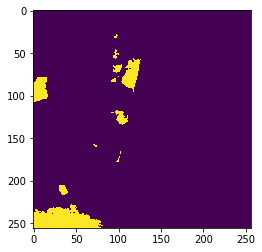

In [23]:
n = 20
plt.imshow(val_target[n, :, :, 0])

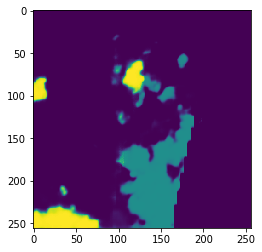

In [24]:
im =  final_model.predict(val_bands[n].reshape((-1, size[0], size[1], band_n)))
plt.imshow(((im[0]).reshape(size)).astype(float))

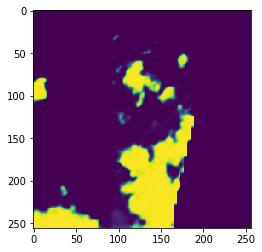

In [25]:
im =  model_deconvnet.predict(val_bands[n].reshape((-1, size[0], size[1], band_n)))
plt.imshow(((im[0]).reshape(size)).astype(float))

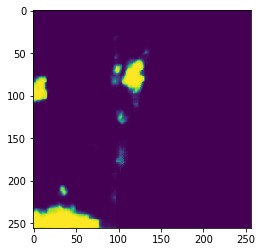

In [26]:
im =  model_unet.predict(val_bands[n].reshape((-1, size[0], size[1], band_n)))
plt.imshow(((im[0]).reshape(size)).astype(float))

In [27]:
model_json = final_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
final_model.save_weights("model.h5")

In [28]:
model_unet_json = model_unet.to_json()
with open("model_unet.json", "w") as json_file:
    json_file.write(model_unet_json)
model_unet.save_weights("model_unet.h5")

In [29]:
model_deconvnet_json = model_deconvnet.to_json()
with open("model_deconvnet.json", "w") as json_file:
    json_file.write(model_deconvnet_json)
model_deconvnet.save_weights("model_deconvnet.h5")